In [1]:
# Import required packages
!pip install -U tensorflow-addons
!pip install -U opencv-python
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from IPython.display import Image

You should consider upgrading via the 'c:\users\aroni\anaconda3\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'c:\users\aroni\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
tf.config.list_physical_devices('GPU')

[]

## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`. 

In [3]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'../data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('../data/noisy_labels.csv', delimiter=',', dtype="int8")

In [4]:
clean_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")
print(clean_labels)

[6 9 9 ... 1 1 5]


For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in `clean_noisy_trainset`. You are encouraged to explore more characteristics of the label noises on the whole dataset. 

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


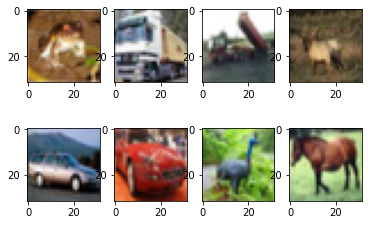

In [5]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))


Let's have a look at how the classes are distributed among the images. Indeed, we have to make sure that one class is not over represented to avoid overfitting over this class. We see from below that each class has somehow the same frequency of allocation among the images of our dataset. Note that this is the case for the noisy labels, but it may not be the case for the "cleaned" labels.

<BarContainer object of 10 artists>

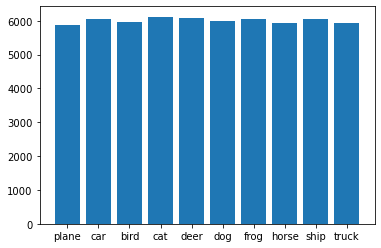

In [6]:
label_named = pd.Series([classes[index] for index in np.concatenate([clean_labels,noisy_labels])])
dict_class_frequency = {}
for classe in classes:
    dict_class_frequency[classe] = label_named.str.count(classe).sum()
plt.bar(list(dict_class_frequency),dict_class_frequency.values())

# 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

In [7]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [8]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [9]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

### 2.2. Model I

Before training our model, let's first prepare our data so our model can easily learn from it. First of all, we convert our image RGB value into ```float32``` and normalzing it to 0-1. Then we apply a label smoothing  to our labels. Basically, the idea is to suggest that the labeling may be inaccurate and avoid overconfident prediction. This is a very good setting for us since we know our label are inacurate so we want our model to not be over confident over the prediction. 

We then separate our data set into training set and test set. The last 45000 images with their noisy labels are used for training and the first 5000 images with their true label are used for testing.

In [6]:
#labels = np.concatenate([clean_labels,noisy_labels[10000:]])
def prep_pixels(train):
	# convert from integers to floats
	train_norm = train.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	# return normalized images
	return train_norm
def smooth_labels(labels, factor=0.1):
	# smooth the labels
	labels *= (1 - factor)
	labels += (factor / labels.shape[1])
	# returned the smoothed labels
	return labels
'''imgs_prep = prep_pixels(imgs)
train = imgs_prep[5000:50000]
test = imgs_prep[:5000]
train_label = smooth_labels(keras.utils.to_categorical(noisy_labels[5000:50000]))
test_labels = smooth_labels(keras.utils.to_categorical(clean_labels[:5000]))'''

'imgs_prep = prep_pixels(imgs)\ntrain = imgs_prep[5000:50000]\ntest = imgs_prep[:5000]\ntrain_label = smooth_labels(keras.utils.to_categorical(noisy_labels[5000:50000]))\ntest_labels = smooth_labels(keras.utils.to_categorical(clean_labels[:5000]))'

<strong>Hyperparameters of our models :<strong>

In [7]:
num_classes = 10
input_shape = (32, 32, 3)
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 100
image_size = 32  # We'll resize input images to this size

positional_emb = True
conv_layers = 2
projection_dim = 128

num_heads = 2
transformer_units = [
    projection_dim,
    projection_dim,
]
transformer_layers = 2
stochastic_depth_rate = 0.1

Again to improve the training of our model and avoid overfitting, we use a very common technique that is data augmentation. In this case, for each images, we create a new image that was either cropped or flipped horizontally or rotated by a random angle or zoomed in by a random factor. As we are gonna see later, an other data augmentation technique can be very handfull in noisy label training which is know as mixup.

In [8]:
data_augmentation = keras.Sequential(
    [
        layers.RandomCrop(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

## <strong>Implement the VGG classifier</strong>

The VGG classifier was our first model and appeared to be the most reliable for this task. Its architecture is shown in the figure below :

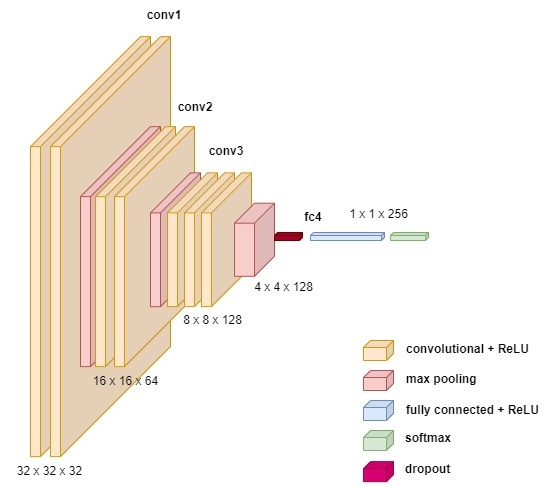

In [9]:
Image(filename = "../figs/vgg16_xml.jpg")

It is composed of a sequence of 3 Convolutional block each reducing the features map by 2 and increasing the filter by 2 as well (features map : \{32,16,8\} and filer : \{32,64,128\}). This Convolutional block are composed of 2 Convolutional layers with a kernel of (3,3) and a padding of 2 so the output has the same size as the input, and a Max Pooling with a kernel of (2,2). The output of this sequence of blocks is fed into a dropout layer with a dropout frequency of 0.5. Since we have a noisy data set, we have to regularize our model so it doesn't over-fit on the training set : this droupout layer forces our model to adapt itself and leverage over-fitting. The last 2 layers form a typical Dense Classification layer with a ReLU dense layer and a Softmax dense layer.

In [10]:
def create_vgg_classifier(num_layer):
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    vgg_encoded = data_augmentation(inputs)
    layer_input = image_size
    for _ in range(num_layer):
        vgg_encoded = layers.Conv2D(layer_input, (3, 3), 
            activation='relu', kernel_initializer='he_uniform',
            padding='same', input_shape=(layer_input, layer_input, 3)
            )(vgg_encoded)
        vgg_encoded = layers.Conv2D(layer_input, (3, 3), 
            activation='relu', kernel_initializer='he_uniform',
            padding='same', input_shape=(layer_input, layer_input, 3)
            )(vgg_encoded)
        vgg_encoded = layers.MaxPooling2D((2,2))(vgg_encoded)
        layer_input *=2
    representation = layers.Flatten()(vgg_encoded)
    representation = layers.Dropout(0.5)(representation)
    features = layers.Dense(layer_input,activation="relu",kernel_initializer="he_uniform")(representation)
    logits = layers.Dense(num_classes,activation="softmax")(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

## <strong>Implement the CCT model</strong>

This model is the second model that was tested against the VGG model and the baseline model. Since it is not our main model we won't go to far in the implementation details. Convolutional Compact Transformer model use the based framework of Vision Transformer model but instead of applying a linear token embedding in the beginning they use a Convolution Block. This allow to encode neighboring information in each token patch which is not possible with only a linear embedding. For those curious in understanding the implementation you can have a look at [Escaping the Big Data Paradigm with
Compact Transformers](https://arxiv.org/pdf/2104.05704.pdf).

<strong> Implement MLP<strong>

In [11]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

<strong>Implement Convolutional tokenizer as a layer<strong>

In [12]:
class Cliper(layers.Layer):
    def __init__(self):
        super(Cliper, self).__init__()
        
    def call(self,label):
        cliped_label = keras.backend.clip(label,0,1)
        return cliped_label

In [13]:
class CCTTokenizer(layers.Layer):
    def __init__(
        self,
        kernel_size=3,
        stride=1,
        padding=1,
        pooling_kernel_size=3,
        pooling_stride=2,
        num_conv_layers=conv_layers,
        num_output_channels=[64, 128],
        positional_emb=positional_emb,
        **kwargs,
    ):
        super(CCTTokenizer, self).__init__(**kwargs)

        # This is our tokenizer.
        self.conv_model = keras.Sequential()
        for i in range(num_conv_layers):
            self.conv_model.add(
                layers.Conv2D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="valid",
                    use_bias=False,
                    activation="relu",
                    kernel_initializer="he_normal",
                )
            )
            self.conv_model.add(
                layers.Conv2D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="valid",
                    use_bias=False,
                    activation="relu",
                    kernel_initializer="he_normal",
                )
            )
            self.conv_model.add(
                layers.MaxPooling2D(pooling_kernel_size, pooling_stride, "same")
            )

        self.positional_emb = positional_emb

    def call(self, images):
        outputs = self.conv_model(images)
        # After passing the images through our mini-network the spatial dimensions
        # are flattened to form sequences.
        reshaped = tf.reshape(
            outputs,
            (-1, tf.shape(outputs)[1] * tf.shape(outputs)[2], tf.shape(outputs)[-1]),
        )
        return reshaped

    def positional_embedding(self, image_size):
        # Positional embeddings are optional in CCT. Here, we calculate
        # the number of sequences and initialize an `Embedding` layer to
        # compute the positional embeddings later.
        if self.positional_emb:
            dummy_inputs = tf.ones((1, image_size, image_size, 3))
            dummy_outputs = self.call(dummy_inputs)
            sequence_length = tf.shape(dummy_outputs)[1]
            projection_dim = tf.shape(dummy_outputs)[-1]

            embed_layer = layers.Embedding(
                input_dim=sequence_length, output_dim=projection_dim
            )
            return embed_layer, sequence_length
        else:
            return None

<strong>Stochastic depth for regularization</strong>

In [14]:
# Referred from: github.com:rwightman/pytorch-image-models.
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super(StochasticDepth, self).__init__(**kwargs)
        self.drop_prob = drop_prop

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

In [15]:
def create_cct_classifier():
    inputs = layers.Input(input_shape)

    # Augment data.
    augmented = data_augmentation(inputs)

    # Encode patches.
    cct_tokenizer = CCTTokenizer()
    encoded_patches = cct_tokenizer(augmented)

    # Apply positional embedding.
    if positional_emb:
        pos_embed, seq_length = cct_tokenizer.positional_embedding(image_size)
        positions = tf.range(start=0, limit=seq_length, delta=1)
        position_embeddings = pos_embed(positions)
        encoded_patches += position_embeddings

    # Calculate Stochastic Depth probabilities.
    dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

    # Create multiple layers of the Transformer block.
    for i in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-5)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        # Skip connection 2.
        x3 = StochasticDepth(dpr[i])(x3)
        encoded_patches = layers.Add()([x3, x2])

    # Apply sequence pooling.
    representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    attention_weights = tf.nn.softmax(layers.Dense(1)(representation), axis=1)
    weighted_representation = tf.matmul(
        attention_weights, representation, transpose_a=True
    )
    weighted_representation = tf.squeeze(weighted_representation, -2)
    weighted_representation = layers.Dropout(0.1)(weighted_representation)
    weighted_representation = layers.Dense(256,activation="relu",kernel_initializer="he_uniform")(weighted_representation)
    # Classify outputs.
    logits = layers.Dense(num_classes)(weighted_representation)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits, activation="softmax")
    return model

## <strong>Implement ResNet</strong>

This model will constitue our 3rd and 4th models that were tested. Again since it is not our main model we won't go to far in the implementation details. ResNet model ([Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)) is rather similar to the VGG model describes above. Instead of having 2 Convolution layers in each block, we have $2n$ Convolution layers and between each 2 layers we have residual (or skip connection). Each Convolution layers is also separated by a Batch Normalization layer. Also there is no Pooling layer between each convolution block. Instead to reduce the feature maps dimensions, we increase the stride of the first Convulotional layer to 2.

In [17]:
def create_resnet_classifier(n):
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # First convolutional layer
    residual = layers.Conv2D(16, (3, 3), 
            activation='relu', kernel_initializer='he_uniform',
            padding='same')(augmented)
    residual = layers.BatchNormalization(trainable=True)(residual)
    # Phase 1
    for _ in range(1,n+1):
        vgg_encoded = layers.Conv2D(16, (3, 3), kernel_initializer='he_uniform',
            padding='same')(residual)
        vgg_encoded = layers.BatchNormalization(trainable=True)(vgg_encoded)
        vgg_encoded = keras.activations.relu(vgg_encoded)
        vgg_encoded = layers.Conv2D(16, (3, 3), kernel_initializer='he_uniform',
            padding='same',activation='relu')(vgg_encoded)
        vgg_encoded = layers.BatchNormalization(trainable=True)(vgg_encoded)
        #vgg_encoded = layers.MaxPooling2D((2,2))(vgg_encoded)
        residual = layers.Add()([vgg_encoded,residual])
    # Phase 2
    for layer in range(1,n+1):
        if layer == 1 :
            vgg_encoded = layers.Conv2D(32, (3, 3),
                strides = 2, kernel_initializer='he_uniform',
                padding='same')(residual)
            vgg_encoded = layers.BatchNormalization(trainable=True)(vgg_encoded)
            vgg_encoded = keras.activations.relu(vgg_encoded)
            vgg_encoded = layers.Conv2D(32, (3, 3),activation="relu", kernel_initializer='he_uniform',
                padding='same')(vgg_encoded)
            vgg_encoded = layers.BatchNormalization(trainable=True)(vgg_encoded)
            residual = layers.Conv2D(32, (3, 3),
                strides = 2, kernel_initializer='he_uniform',
                padding='same')(residual)
            residual = layers.Add()([vgg_encoded,residual])
        else :
            vgg_encoded = layers.Conv2D(32, (3, 3),
                strides = 1, kernel_initializer='he_uniform',
                padding='same')(residual)
            vgg_encoded = layers.BatchNormalization(trainable=True)(vgg_encoded)
            vgg_encoded = keras.activations.relu(vgg_encoded)
            vgg_encoded = layers.Conv2D(32, (3, 3),activation="relu", kernel_initializer='he_uniform',
                padding='same')(vgg_encoded)
            vgg_encoded = layers.BatchNormalization(trainable=True)(vgg_encoded)
            residual = layers.Add()([vgg_encoded,residual])
    # Phase 3:
    for layer in range(1,n+1):
        if layer == 1 :
            vgg_encoded = layers.Conv2D(64, (3, 3),
                strides = 2, kernel_initializer='he_uniform',
                padding='same')(residual)
            vgg_encoded = layers.BatchNormalization(trainable=True)(vgg_encoded)
            vgg_encoded = keras.activations.relu(vgg_encoded)
            vgg_encoded = layers.Conv2D(64, (3, 3),activation="relu", kernel_initializer='he_uniform',
                padding='same')(vgg_encoded)
            vgg_encoded = layers.BatchNormalization(trainable=True)(vgg_encoded)
            residual = layers.Conv2D(64, (3, 3),
                strides = 2, kernel_initializer='he_uniform',
                padding='same')(residual)
            residual = layers.Add()([vgg_encoded,residual])
        else :
            vgg_encoded = layers.Conv2D(64, (3, 3),
                strides = 1, kernel_initializer='he_uniform',
                padding='same')(residual)
            vgg_encoded = layers.BatchNormalization(trainable=True)(vgg_encoded)
            vgg_encoded = keras.activations.relu(vgg_encoded)
            vgg_encoded = layers.Conv2D(64, (3, 3),activation="relu", kernel_initializer='he_uniform',
                padding='same')(vgg_encoded)
            vgg_encoded = layers.BatchNormalization(trainable=True)(vgg_encoded)
            residual = layers.Add()([vgg_encoded,residual])
    residual = layers.GlobalAveragePooling2D()(residual)
    representation = layers.Flatten()(residual)
    representation = layers.Dropout(0.5)(representation)
    features = layers.Dense(64,activation="relu",kernel_initializer="he_uniform")(representation)
    logits = layers.Dense(num_classes, activation="softmax")(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

Each model were trained with the AdamW optimizer, a learning rate of $1e-3$ and a decaying weight of $1e-4$. The training was run for 100 epochs with an early stopping based on the validation accuracy and a mini-batch size of 128. 

In [15]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "./tmp/checkpoint_"+str(model.name)
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )
    early_stoping_callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15)
    history = model.fit(
        x=train,
        y=train_label,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback,early_stoping_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(test, test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

## ```Training VGG```

In [37]:
vgg_classifier = create_vgg_classifier(3)
vgg_classifier._name = 'model_vgg_classifier'
history_vgg_classifier = run_experiment(vgg_classifier)

Epoch 1/100
317/317 [==============================] - 7s 17ms/step - loss: 2.2947 - accuracy: 0.1386 - top-5-accuracy: 0.5646 - val_loss: 2.2673 - val_accuracy: 0.1709 - val_top-5-accuracy: 0.6153
Epoch 2/100
317/317 [==============================] - 5s 15ms/step - loss: 2.2691 - accuracy: 0.1684 - top-5-accuracy: 0.6045 - val_loss: 2.2564 - val_accuracy: 0.1787 - val_top-5-accuracy: 0.6058
Epoch 3/100
317/317 [==============================] - 5s 15ms/step - loss: 2.2569 - accuracy: 0.1849 - top-5-accuracy: 0.6157 - val_loss: 2.2451 - val_accuracy: 0.2036 - val_top-5-accuracy: 0.6311
Epoch 4/100
317/317 [==============================] - 5s 15ms/step - loss: 2.2500 - accuracy: 0.1926 - top-5-accuracy: 0.6238 - val_loss: 2.2399 - val_accuracy: 0.1973 - val_top-5-accuracy: 0.6200
Epoch 5/100
317/317 [==============================] - 5s 15ms/step - loss: 2.2416 - accuracy: 0.2025 - top-5-accuracy: 0.6258 - val_loss: 2.2256 - val_accuracy: 0.2124 - val_top-5-accuracy: 0.6358
Epoch 6/10

## ```Training CCT```

In [39]:
cct_classifier = create_cct_classifier()
cct_classifier._name = 'model_cct_classifier'
history_cct_classifier = run_experiment(cct_classifier)

Epoch 1/100
317/317 [==============================] - 13s 31ms/step - loss: 2.3268 - accuracy: 0.1188 - top-5-accuracy: 0.5371 - val_loss: 2.3013 - val_accuracy: 0.1164 - val_top-5-accuracy: 0.5507
Epoch 2/100
317/317 [==============================] - 9s 28ms/step - loss: 2.2874 - accuracy: 0.1374 - top-5-accuracy: 0.5821 - val_loss: 2.2751 - val_accuracy: 0.1420 - val_top-5-accuracy: 0.6047
Epoch 3/100
317/317 [==============================] - 9s 29ms/step - loss: 2.2763 - accuracy: 0.1502 - top-5-accuracy: 0.5999 - val_loss: 2.2632 - val_accuracy: 0.1633 - val_top-5-accuracy: 0.6151
Epoch 4/100
317/317 [==============================] - 9s 28ms/step - loss: 2.2687 - accuracy: 0.1633 - top-5-accuracy: 0.6064 - val_loss: 2.2493 - val_accuracy: 0.1798 - val_top-5-accuracy: 0.6364
Epoch 5/100
317/317 [==============================] - 9s 28ms/step - loss: 2.2617 - accuracy: 0.1712 - top-5-accuracy: 0.6140 - val_loss: 2.2433 - val_accuracy: 0.1944 - val_top-5-accuracy: 0.6367
Epoch 6/1

## ```Training ResNet20```

In [41]:
resnet20_classifier = create_resnet_classifier(1)
resnet20_classifier._name = 'model_resnet20_classifier'
history_resnet20_classifier = run_experiment(resnet20_classifier)

Epoch 1/100
317/317 [==============================] - 8s 19ms/step - loss: 2.3501 - accuracy: 0.1247 - top-5-accuracy: 0.5516 - val_loss: 2.2990 - val_accuracy: 0.1244 - val_top-5-accuracy: 0.5478
Epoch 2/100
317/317 [==============================] - 5s 17ms/step - loss: 2.2879 - accuracy: 0.1457 - top-5-accuracy: 0.5851 - val_loss: 2.2680 - val_accuracy: 0.1727 - val_top-5-accuracy: 0.6171
Epoch 3/100
317/317 [==============================] - 5s 17ms/step - loss: 2.2731 - accuracy: 0.1608 - top-5-accuracy: 0.6038 - val_loss: 2.2590 - val_accuracy: 0.1698 - val_top-5-accuracy: 0.6287
Epoch 4/100
317/317 [==============================] - 5s 17ms/step - loss: 2.2650 - accuracy: 0.1722 - top-5-accuracy: 0.6108 - val_loss: 2.2451 - val_accuracy: 0.1909 - val_top-5-accuracy: 0.6309
Epoch 5/100
317/317 [==============================] - 5s 17ms/step - loss: 2.2600 - accuracy: 0.1810 - top-5-accuracy: 0.6139 - val_loss: 2.2384 - val_accuracy: 0.2071 - val_top-5-accuracy: 0.6384
Epoch 6/10

## ```Training ResNet44```

In [43]:
resnet44_classifier = create_resnet_classifier(7)
resnet44_classifier._name = 'model_resnet44_classifier'
history_resnet44_classifier = run_experiment(resnet44_classifier)

Epoch 1/100
317/317 [==============================] - 28s 71ms/step - loss: 2.4494 - accuracy: 0.1117 - top-5-accuracy: 0.5186 - val_loss: 2.3001 - val_accuracy: 0.1147 - val_top-5-accuracy: 0.5322
Epoch 2/100
317/317 [==============================] - 22s 68ms/step - loss: 2.3061 - accuracy: 0.1232 - top-5-accuracy: 0.5452 - val_loss: 2.2755 - val_accuracy: 0.1489 - val_top-5-accuracy: 0.6036
Epoch 3/100
317/317 [==============================] - 21s 67ms/step - loss: 2.2909 - accuracy: 0.1400 - top-5-accuracy: 0.5687 - val_loss: 2.2691 - val_accuracy: 0.1487 - val_top-5-accuracy: 0.6096
Epoch 4/100
317/317 [==============================] - 21s 68ms/step - loss: 2.2762 - accuracy: 0.1549 - top-5-accuracy: 0.5973 - val_loss: 2.2579 - val_accuracy: 0.1693 - val_top-5-accuracy: 0.6164
Epoch 5/100
317/317 [==============================] - 22s 68ms/step - loss: 2.2651 - accuracy: 0.1677 - top-5-accuracy: 0.6100 - val_loss: 2.2479 - val_accuracy: 0.1942 - val_top-5-accuracy: 0.6269
Epoch

317/317 [==============================] - 21s 67ms/step - loss: 2.1361 - accuracy: 0.3097 - top-5-accuracy: 0.6683 - val_loss: 2.1707 - val_accuracy: 0.2767 - val_top-5-accuracy: 0.6469
Epoch 43/100
317/317 [==============================] - 22s 68ms/step - loss: 2.1356 - accuracy: 0.3113 - top-5-accuracy: 0.6671 - val_loss: 2.1703 - val_accuracy: 0.2864 - val_top-5-accuracy: 0.6464
Epoch 44/100
317/317 [==============================] - 21s 67ms/step - loss: 2.1322 - accuracy: 0.3147 - top-5-accuracy: 0.6684 - val_loss: 2.1747 - val_accuracy: 0.2813 - val_top-5-accuracy: 0.6429
Epoch 45/100
317/317 [==============================] - 22s 68ms/step - loss: 2.1322 - accuracy: 0.3138 - top-5-accuracy: 0.6674 - val_loss: 2.1596 - val_accuracy: 0.2962 - val_top-5-accuracy: 0.6576
Epoch 46/100
317/317 [==============================] - 21s 67ms/step - loss: 2.1318 - accuracy: 0.3151 - top-5-accuracy: 0.6683 - val_loss: 2.1642 - val_accuracy: 0.2876 - val_top-5-accuracy: 0.6538
Epoch 47/100


<strong>Training history of our models :</strong>

Text(0.5, 1.0, 'ResNet44 History training')

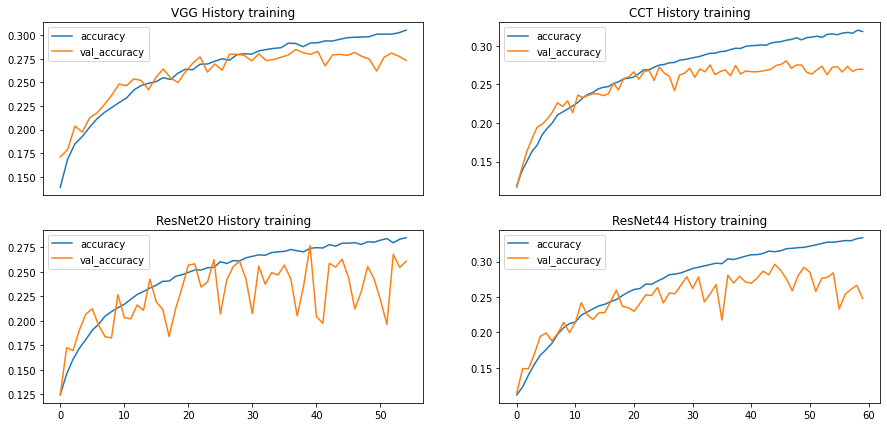

In [92]:
plt.rcParams["figure.figsize"] = (15,7)
fig, axs = plt.subplots(2,2)
pd.DataFrame(history_vgg_classifier.history)[["accuracy","val_accuracy"]].plot(ax = axs[0,0])
axs[0,0].set_title("VGG History training")
axs[0,0].get_xaxis().set_ticks([])
pd.DataFrame(history_cct_classifier.history)[["accuracy","val_accuracy"]].plot(ax=axs[0,1])
axs[0,1].set_title("CCT History training")
axs[0,1].get_xaxis().set_ticks([])
pd.DataFrame(history_resnet20_classifier.history)[["accuracy","val_accuracy"]].plot(ax=axs[1,0])
axs[1,0].set_title("ResNet20 History training")
pd.DataFrame(history_resnet44_classifier.history)[["accuracy","val_accuracy"]].plot(ax = axs[1,1])
axs[1,1].set_title("ResNet44 History training")


<strong>Accruacy comparaison between the model on the test set</strong>

| Model | Accuracy | #Params | Time per epoch |
| :-----: | :--------: | :-------: | :--------------: |
| VGG | 66.04% | 0.8M | 5s |
| CCT | 62.02% | 0.63M | 9s |
| ResNet20 | 63.7%| 0.10M| 5s|
|ResNet44 | <strong>67.24%</strong>|0.69M| 21s |

We can see from this table that the VGG model reach a good accuracy with a low computational time but a high memory cost.

### 2.3. Model II

<strong>Create a label cleaning network</strong>

To improve our model accuracy on our training set, we are going to train a deep neural network as in [Multi-Label Fashion Image Classification with Minimal Human Supervision](https://openaccess.thecvf.com/content_ICCV_2017_workshops/papers/w32/Inoue_Multi-Label_Fashion_Image_ICCV_2017_paper.pdf) that will relabel our noisy label and train our <strong>Model I</strong> on the new labels. Similarly to [Inoue et al.(2017)](https://openaccess.thecvf.com/content_ICCV_2017_workshops/papers/w32/Inoue_Multi-Label_Fashion_Image_ICCV_2017_paper.pdf), we decide to decompose the training into two phases : 
 1. Training a label cleaning network with the cleaned labels
 2. Train our <strong>Model I</strong> on the new labels
 
 We ended up with the following architecture :

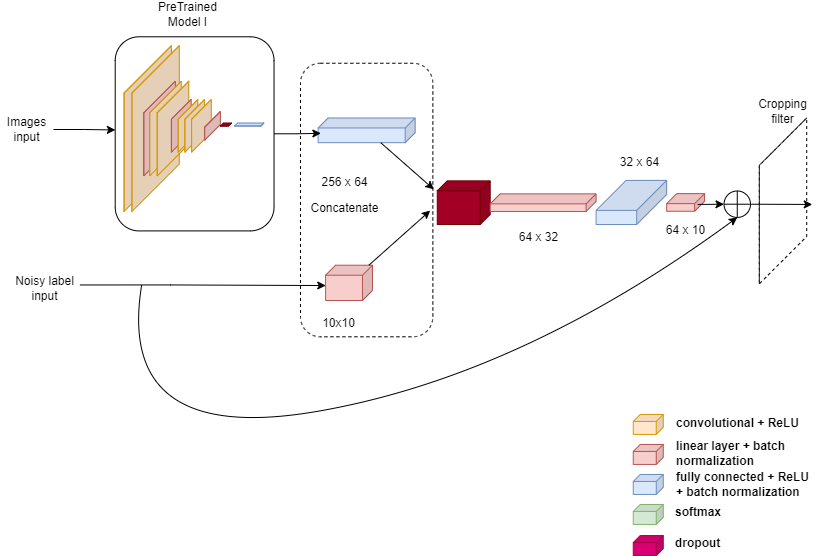

In [4]:
Image(filename="../figs/vgg16_xml.drawio.png")

If [Inoue et al.(2017)](https://openaccess.thecvf.com/content_ICCV_2017_workshops/papers/w32/Inoue_Multi-Label_Fashion_Image_ICCV_2017_paper.pdf) decided to replace every linear layer by a ReLU + BatchNormalization layers, we have found that keeping some linear layers + BatchNormalization worked better for this case.
 
 For training this network, we separated our clean labels into a training set and a test set. The first 9000 images and clean labels were used for training and the last 1000 images and labels were used for testing. Again we use a batchsize of 128 and the same learning rate. We also use our pretrained <strong>```Model I```</strong> on the noisy label as our initializer of the feature extractor.

In [21]:
train_imgs_cleaning = imgs_prep[:9000]
noisy_train_labels = smooth_labels(keras.utils.to_categorical(noisy_labels[:9000]))
cleaned_train_labels = smooth_labels(keras.utils.to_categorical(clean_labels[:9000]))
test_imgs_cleaning = imgs_prep[9000:10000]
noisy_test_labels = smooth_labels(keras.utils.to_categorical(noisy_labels[9000:10000]))
cleaned_test_labels = smooth_labels(keras.utils.to_categorical(clean_labels[9000:]))

In [22]:
def create_label_cleaner_clipped(model):
    image_inputs = model.input
    representation = layers.Dropout(0.2)(model.layers[-2].output)
    representation = layers.Dense(64,activation="relu",kernel_initializer="he_uniform")(representation)
    representation = layers.BatchNormalization(trainable=True)(representation)
    # Create the Keras model.
    base_CNN = keras.Model(inputs=image_inputs, outputs=representation)
    label_input = layers.Input(shape=(10,))
    label_input = layers.Dense(10, activation = "linear")(label_input)
    combined_inputs = layers.concatenate([base_CNN.output,label_input])
    combined_inputs = layers.Dropout(0.5)(combined_inputs)
    label_cleaning_network = layers.Dense(32,activation="linear",kernel_initializer='he_uniform')(combined_inputs)
    label_cleaning_network = layers.BatchNormalization(trainable=True)(label_cleaning_network)
    label_cleaning_network = layers.Dense(64,activation="relu",kernel_initializer='he_uniform')(combined_inputs)
    label_cleaning_network = layers.BatchNormalization(trainable=True)(label_cleaning_network)
    label_cleaning_network = layers.Dense(10,activation="linear",kernel_initializer='he_uniform')(label_cleaning_network)
    label_cleaning_network = layers.BatchNormalization(trainable=True)(label_cleaning_network)
    label_cleaning_network = layers.Add()([label_input,label_cleaning_network])
    label_cleaning_network = Cliper()(label_cleaning_network)
    model = keras.Model(inputs=[base_CNN.input,label_input], outputs=label_cleaning_network)
    return model

<strong>Train the label cleaning network ([Multi-Label Fashion Image Classification with Minimal Human Supervision](https://openaccess.thecvf.com/content_ICCV_2017_workshops/papers/w32/Inoue_Multi-Label_Fashion_Image_ICCV_2017_paper.pdf))<strong/>

In [23]:
batch_size = 128
num_epoch = 150
def run_cleaning_label(model):
    optimizer = tf.optimizers.Adam(
        learning_rate=learning_rate
    )
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )
    checkpoint_filepath = "./tmp/checkpoint_"+str(model.name)
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )
    early_stoping_callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15)

    history = model.fit(
        x=[train_imgs_cleaning,noisy_train_labels],
        y=cleaned_train_labels,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback,early_stoping_callback],
    )
    model.load_weights(checkpoint_filepath)
    _, accuracy, _ = model.evaluate([test_imgs_cleaning,noisy_test_labels], cleaned_test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    
    return history

In [51]:
cleaning_network = create_label_cleaner_clipped(vgg_classifier)
cleaning_network._name = "cleaning_network_vgg_clipped"
history_cleaning_vgg = run_cleaning_label(cleaning_network)

Epoch 1/100
64/64 [==============================] - 4s 29ms/step - loss: 2.1012 - accuracy: 0.3002 - top-5-accuracy: 0.8337 - val_loss: 1.9119 - val_accuracy: 0.5456 - val_top-5-accuracy: 0.9367
Epoch 2/100
64/64 [==============================] - 1s 17ms/step - loss: 1.9256 - accuracy: 0.4473 - top-5-accuracy: 0.9322 - val_loss: 1.8535 - val_accuracy: 0.5967 - val_top-5-accuracy: 0.9489
Epoch 3/100
64/64 [==============================] - 1s 16ms/step - loss: 1.8804 - accuracy: 0.5014 - top-5-accuracy: 0.9502 - val_loss: 1.8420 - val_accuracy: 0.5667 - val_top-5-accuracy: 0.9456
Epoch 4/100
64/64 [==============================] - 1s 17ms/step - loss: 1.8524 - accuracy: 0.5495 - top-5-accuracy: 0.9558 - val_loss: 1.8210 - val_accuracy: 0.6089 - val_top-5-accuracy: 0.9689
Epoch 5/100
64/64 [==============================] - 1s 20ms/step - loss: 1.8328 - accuracy: 0.5800 - top-5-accuracy: 0.9601 - val_loss: 1.8106 - val_accuracy: 0.6178 - val_top-5-accuracy: 0.9722
Epoch 6/100
64/64 [=

Epoch 43/100
64/64 [==============================] - 1s 16ms/step - loss: 1.7050 - accuracy: 0.7623 - top-5-accuracy: 0.9967 - val_loss: 1.7507 - val_accuracy: 0.7022 - val_top-5-accuracy: 0.9956
Epoch 44/100
64/64 [==============================] - 1s 16ms/step - loss: 1.7045 - accuracy: 0.7716 - top-5-accuracy: 0.9958 - val_loss: 1.7435 - val_accuracy: 0.7200 - val_top-5-accuracy: 0.9967
Epoch 45/100
64/64 [==============================] - 1s 16ms/step - loss: 1.7034 - accuracy: 0.7714 - top-5-accuracy: 0.9962 - val_loss: 1.7510 - val_accuracy: 0.7033 - val_top-5-accuracy: 0.9944
Epoch 46/100
64/64 [==============================] - 1s 16ms/step - loss: 1.7006 - accuracy: 0.7717 - top-5-accuracy: 0.9960 - val_loss: 1.7602 - val_accuracy: 0.6800 - val_top-5-accuracy: 0.9911
Epoch 47/100
64/64 [==============================] - 1s 16ms/step - loss: 1.6985 - accuracy: 0.7768 - top-5-accuracy: 0.9959 - val_loss: 1.7299 - val_accuracy: 0.7244 - val_top-5-accuracy: 0.9911
Epoch 48/100
64

In [52]:
cleaning_network = create_label_cleaner_clipped(cct_classifier)
cleaning_network._name = "cleaning_network_cct_clipped"
history_cleaning_cct = run_cleaning_label(cleaning_network)

Epoch 1/100
64/64 [==============================] - 7s 45ms/step - loss: 2.0771 - accuracy: 0.3293 - top-5-accuracy: 0.8552 - val_loss: 1.8976 - val_accuracy: 0.5444 - val_top-5-accuracy: 0.9267
Epoch 2/100
64/64 [==============================] - 2s 30ms/step - loss: 1.9097 - accuracy: 0.4731 - top-5-accuracy: 0.9375 - val_loss: 1.8502 - val_accuracy: 0.6067 - val_top-5-accuracy: 0.9511
Epoch 3/100
64/64 [==============================] - 2s 29ms/step - loss: 1.8564 - accuracy: 0.5312 - top-5-accuracy: 0.9607 - val_loss: 1.8215 - val_accuracy: 0.5989 - val_top-5-accuracy: 0.9656
Epoch 4/100
64/64 [==============================] - 2s 30ms/step - loss: 1.8353 - accuracy: 0.5746 - top-5-accuracy: 0.9694 - val_loss: 1.8045 - val_accuracy: 0.6256 - val_top-5-accuracy: 0.9833
Epoch 5/100
64/64 [==============================] - 2s 30ms/step - loss: 1.8196 - accuracy: 0.5954 - top-5-accuracy: 0.9770 - val_loss: 1.7993 - val_accuracy: 0.6500 - val_top-5-accuracy: 0.9756
Epoch 6/100
64/64 [=

In [53]:
cleaning_network = create_label_cleaner_clipped(resnet20_classifier)
cleaning_network._name = "cleaning_network_resnet20_clipped"
history_cleaning_resnet20 = run_cleaning_label(cleaning_network)

Epoch 1/100
64/64 [==============================] - 4s 30ms/step - loss: 2.0541 - accuracy: 0.3278 - top-5-accuracy: 0.8663 - val_loss: 1.9707 - val_accuracy: 0.4144 - val_top-5-accuracy: 0.9189
Epoch 2/100
64/64 [==============================] - 1s 18ms/step - loss: 1.9258 - accuracy: 0.4306 - top-5-accuracy: 0.9332 - val_loss: 1.9939 - val_accuracy: 0.3956 - val_top-5-accuracy: 0.9156
Epoch 3/100
64/64 [==============================] - 1s 18ms/step - loss: 1.8894 - accuracy: 0.4567 - top-5-accuracy: 0.9535 - val_loss: 1.8776 - val_accuracy: 0.4667 - val_top-5-accuracy: 0.9556
Epoch 4/100
64/64 [==============================] - 1s 19ms/step - loss: 1.8645 - accuracy: 0.5036 - top-5-accuracy: 0.9553 - val_loss: 1.8624 - val_accuracy: 0.5111 - val_top-5-accuracy: 0.9544
Epoch 5/100
64/64 [==============================] - 1s 19ms/step - loss: 1.8487 - accuracy: 0.5190 - top-5-accuracy: 0.9621 - val_loss: 1.8465 - val_accuracy: 0.5122 - val_top-5-accuracy: 0.9644
Epoch 6/100
64/64 [=

Epoch 43/100
64/64 [==============================] - 1s 17ms/step - loss: 1.7423 - accuracy: 0.7036 - top-5-accuracy: 0.9932 - val_loss: 1.7912 - val_accuracy: 0.6600 - val_top-5-accuracy: 0.9922
Epoch 44/100
64/64 [==============================] - 1s 17ms/step - loss: 1.7451 - accuracy: 0.6883 - top-5-accuracy: 0.9943 - val_loss: 1.7668 - val_accuracy: 0.6600 - val_top-5-accuracy: 0.9967
Epoch 45/100
64/64 [==============================] - 1s 17ms/step - loss: 1.7474 - accuracy: 0.6915 - top-5-accuracy: 0.9936 - val_loss: 1.8232 - val_accuracy: 0.6178 - val_top-5-accuracy: 0.9967
Epoch 46/100
64/64 [==============================] - 1s 17ms/step - loss: 1.7425 - accuracy: 0.6974 - top-5-accuracy: 0.9928 - val_loss: 1.7746 - val_accuracy: 0.6467 - val_top-5-accuracy: 0.9933
Epoch 47/100
64/64 [==============================] - 1s 17ms/step - loss: 1.7434 - accuracy: 0.6900 - top-5-accuracy: 0.9953 - val_loss: 1.7781 - val_accuracy: 0.6589 - val_top-5-accuracy: 0.9911
Epoch 48/100
64

In [54]:
cleaning_network = create_label_cleaner_clipped(resnet44_classifier)
cleaning_network._name = "cleaning_network_resnet44_clipped"
history_cleaning_resnet44 = run_cleaning_label(cleaning_network)

Epoch 1/100
64/64 [==============================] - 11s 86ms/step - loss: 2.0538 - accuracy: 0.3533 - top-5-accuracy: 0.8611 - val_loss: 1.9014 - val_accuracy: 0.5544 - val_top-5-accuracy: 0.9444
Epoch 2/100
64/64 [==============================] - 4s 69ms/step - loss: 1.9004 - accuracy: 0.5262 - top-5-accuracy: 0.9340 - val_loss: 1.8634 - val_accuracy: 0.5656 - val_top-5-accuracy: 0.9511
Epoch 3/100
64/64 [==============================] - 5s 72ms/step - loss: 1.8496 - accuracy: 0.5944 - top-5-accuracy: 0.9481 - val_loss: 1.8116 - val_accuracy: 0.6433 - val_top-5-accuracy: 0.9633
Epoch 4/100
64/64 [==============================] - 4s 65ms/step - loss: 1.8143 - accuracy: 0.6274 - top-5-accuracy: 0.9627 - val_loss: 1.8050 - val_accuracy: 0.6233 - val_top-5-accuracy: 0.9633
Epoch 5/100
64/64 [==============================] - 4s 70ms/step - loss: 1.7960 - accuracy: 0.6573 - top-5-accuracy: 0.9679 - val_loss: 1.7781 - val_accuracy: 0.6800 - val_top-5-accuracy: 0.9778
Epoch 6/100
64/64 [

Epoch 43/100
64/64 [==============================] - 4s 65ms/step - loss: 1.6571 - accuracy: 0.8483 - top-5-accuracy: 0.9980 - val_loss: 1.7520 - val_accuracy: 0.7211 - val_top-5-accuracy: 0.9967
Epoch 44/100
64/64 [==============================] - 4s 65ms/step - loss: 1.6554 - accuracy: 0.8506 - top-5-accuracy: 0.9990 - val_loss: 1.7260 - val_accuracy: 0.7578 - val_top-5-accuracy: 1.0000
Epoch 45/100
64/64 [==============================] - 4s 65ms/step - loss: 1.6663 - accuracy: 0.8311 - top-5-accuracy: 0.9983 - val_loss: 1.7696 - val_accuracy: 0.7011 - val_top-5-accuracy: 1.0000
Epoch 46/100
64/64 [==============================] - 4s 67ms/step - loss: 1.6566 - accuracy: 0.8467 - top-5-accuracy: 0.9978 - val_loss: 1.7414 - val_accuracy: 0.7444 - val_top-5-accuracy: 0.9989
Epoch 47/100
64/64 [==============================] - 4s 65ms/step - loss: 1.6562 - accuracy: 0.8486 - top-5-accuracy: 0.9988 - val_loss: 1.7354 - val_accuracy: 0.7533 - val_top-5-accuracy: 0.9978
Epoch 48/100
64

<strong>Training history of our cleaning label models :</strong>

Text(0.5, 1.0, 'ResNet44 History training')

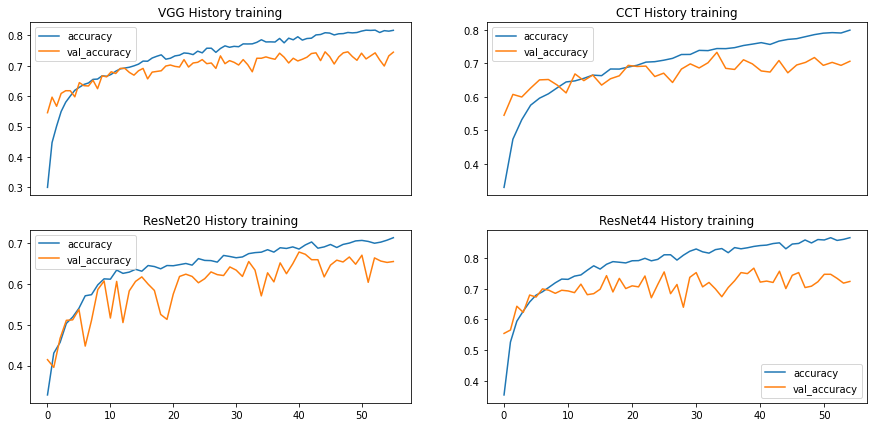

In [91]:
plt.rcParams["figure.figsize"] = (15,7)
fig, axs = plt.subplots(2,2)
pd.DataFrame(history_cleaning_vgg.history)[["accuracy","val_accuracy"]].plot(ax = axs[0,0])
axs[0,0].set_title("VGG History training")
axs[0,0].get_xaxis().set_ticks([])
pd.DataFrame(history_cleaning_cct.history)[["accuracy","val_accuracy"]].plot(ax=axs[0,1])
axs[0,1].set_title("CCT History training")
axs[0,1].get_xaxis().set_ticks([])
pd.DataFrame(history_cleaning_resnet20.history)[["accuracy","val_accuracy"]].plot(ax=axs[1,0])
axs[1,0].set_title("ResNet20 History training")
pd.DataFrame(history_cleaning_resnet44.history)[["accuracy","val_accuracy"]].plot(ax = axs[1,1])
axs[1,1].set_title("ResNet44 History training")

<strong>Accruacy comparaison between the model on the test set</strong>

| Model | Accuracy | #Params | Time per epoch |
| :-----: | :--------: | :-------: | :--------------: |
| VGG | 76.6% | 0.82M | 1s |
| CCT | 70.5% | 0.65M | 2s |
| ResNet20 | 71.3%| 0.12M| 1s|
|ResNet44 | <strong>77.2%</strong>|0.71M| 4s |

Again VGG as a very good accuracy and very low computational time.

<strong>Train with the new predicted label</strong>

Once we have trained our label cleaning network, we feed the noisy label to get the new corrected label that will be use for training. Again we separate our dataset into a training set (composed of the 45,000 last images and a mix of corrected labels and cleaned labels) and a testing set (composed of the 5,000 first images and cleaned labels). Since we are fine tuning, our <strong>Model I</strong>, we reduce the learning rate to $1e-4$ to end up with a better accuracy.

In [24]:
learning_rate=1e-3
def run_experiment2(model,name):
    # Compute the new predicted label from the base Encoder used
    cleaning_network = create_label_cleaner_clipped(model)
    cleaning_network.load_weights("./tmp/checkpoint_cleaning_network_"+name+"_clipped")
    train = imgs_prep[5000:50000]
    test = imgs_prep[:5000]
    train_labels = smooth_labels(keras.utils.to_categorical(labels[5000:50000]))
    test_cleaned_labels = smooth_labels(keras.utils.to_categorical(labels[:5000]))
    train_cleaned_labels = tf.argmax(cleaning_network.predict([train[2000:],train_labels[2000:]]),axis=1)
    train_cleaned_labels = smooth_labels(keras.utils.to_categorical(tf.concat([labels[5000:7000],train_cleaned_labels],axis=0)))
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "./tmp/checkpoint_"+str(model.name)
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )
    early_stoping_callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

    history = model.fit(
        x=train,
        y=train_cleaned_labels,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback,early_stoping_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(test, test_cleaned_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [93]:
learning_rate = 1e-4
vgg_classifier = create_vgg_classifier(3)
vgg_classifier.load_weights("./tmp/checkpoint_model_vgg_classifier")
vgg_classifier._name = 'model_vgg_classifier_2'
history_vgg_2 = run_experiment2(vgg_classifier,"vgg")

Epoch 1/100
317/317 [==============================] - 6s 17ms/step - loss: 1.1295 - accuracy: 0.7285 - top-5-accuracy: 0.9776 - val_loss: 0.9225 - val_accuracy: 0.8267 - val_top-5-accuracy: 0.9911
Epoch 2/100
317/317 [==============================] - 5s 15ms/step - loss: 1.0513 - accuracy: 0.7607 - top-5-accuracy: 0.9838 - val_loss: 0.9540 - val_accuracy: 0.7987 - val_top-5-accuracy: 0.9893
Epoch 3/100
317/317 [==============================] - 5s 15ms/step - loss: 1.0201 - accuracy: 0.7738 - top-5-accuracy: 0.9856 - val_loss: 0.9721 - val_accuracy: 0.7911 - val_top-5-accuracy: 0.9891
Epoch 4/100
317/317 [==============================] - 5s 15ms/step - loss: 1.0068 - accuracy: 0.7760 - top-5-accuracy: 0.9873 - val_loss: 0.9593 - val_accuracy: 0.7953 - val_top-5-accuracy: 0.9891
Epoch 5/100
317/317 [==============================] - 5s 15ms/step - loss: 0.9884 - accuracy: 0.7864 - top-5-accuracy: 0.9875 - val_loss: 0.9677 - val_accuracy: 0.7902 - val_top-5-accuracy: 0.9898
Epoch 6/10

In [94]:
cct_classifier = create_cct_classifier()
cct_classifier.load_weights("./tmp/checkpoint_model_cct_classifier")
cct_classifier._name = 'model_cct_classifier_2'
history_cct_2 = run_experiment2(cct_classifier,"cct")

Epoch 1/100
317/317 [==============================] - 13s 30ms/step - loss: 1.1015 - accuracy: 0.7311 - top-5-accuracy: 0.9827 - val_loss: 0.9502 - val_accuracy: 0.7962 - val_top-5-accuracy: 0.9913
Epoch 2/100
317/317 [==============================] - 9s 27ms/step - loss: 1.0371 - accuracy: 0.7543 - top-5-accuracy: 0.9878 - val_loss: 0.9880 - val_accuracy: 0.7764 - val_top-5-accuracy: 0.9920
Epoch 3/100
317/317 [==============================] - 9s 28ms/step - loss: 1.0153 - accuracy: 0.7658 - top-5-accuracy: 0.9893 - val_loss: 0.9320 - val_accuracy: 0.7998 - val_top-5-accuracy: 0.9940
Epoch 4/100
317/317 [==============================] - 9s 28ms/step - loss: 0.9955 - accuracy: 0.7740 - top-5-accuracy: 0.9897 - val_loss: 0.9076 - val_accuracy: 0.8133 - val_top-5-accuracy: 0.9956
Epoch 5/100
317/317 [==============================] - 9s 27ms/step - loss: 0.9885 - accuracy: 0.7762 - top-5-accuracy: 0.9905 - val_loss: 0.9257 - val_accuracy: 0.8011 - val_top-5-accuracy: 0.9938
Epoch 6/1

In [95]:
resnet20_classifier = create_resnet_classifier(1)
resnet20_classifier.load_weights("./tmp/checkpoint_model_resnet20_classifier")
resnet20_classifier._name = 'model_resnet20_classifier_2'
history_resnet20_2 = run_experiment2(resnet20_classifier,"resnet20")

Epoch 1/100
317/317 [==============================] - 8s 19ms/step - loss: 1.1995 - accuracy: 0.7056 - top-5-accuracy: 0.9776 - val_loss: 1.2329 - val_accuracy: 0.6962 - val_top-5-accuracy: 0.9687
Epoch 2/100
317/317 [==============================] - 5s 17ms/step - loss: 1.1361 - accuracy: 0.7255 - top-5-accuracy: 0.9810 - val_loss: 1.3574 - val_accuracy: 0.6400 - val_top-5-accuracy: 0.9647
Epoch 3/100
317/317 [==============================] - 5s 17ms/step - loss: 1.1176 - accuracy: 0.7300 - top-5-accuracy: 0.9820 - val_loss: 1.1834 - val_accuracy: 0.6873 - val_top-5-accuracy: 0.9853
Epoch 4/100
317/317 [==============================] - 5s 17ms/step - loss: 1.0984 - accuracy: 0.7402 - top-5-accuracy: 0.9840 - val_loss: 1.1321 - val_accuracy: 0.7078 - val_top-5-accuracy: 0.9716
Epoch 5/100
317/317 [==============================] - 5s 17ms/step - loss: 1.0913 - accuracy: 0.7418 - top-5-accuracy: 0.9829 - val_loss: 1.1184 - val_accuracy: 0.7233 - val_top-5-accuracy: 0.9896
Epoch 6/10

In [97]:
resnet44_classifier = create_resnet_classifier(7)
resnet44_classifier.load_weights("./tmp/checkpoint_model_resnet44_classifier")
resnet44_classifier._name='model_resnet44_classifier_2'
history_resnet44_2 = run_experiment2(resnet44_classifier,"resnet44")

Epoch 1/100
317/317 [==============================] - 28s 72ms/step - loss: 1.0967 - accuracy: 0.7580 - top-5-accuracy: 0.9766 - val_loss: 1.0902 - val_accuracy: 0.7416 - val_top-5-accuracy: 0.9818
Epoch 2/100
317/317 [==============================] - 22s 68ms/step - loss: 1.0226 - accuracy: 0.7837 - top-5-accuracy: 0.9831 - val_loss: 0.9781 - val_accuracy: 0.7936 - val_top-5-accuracy: 0.9862
Epoch 3/100
317/317 [==============================] - 21s 68ms/step - loss: 0.9949 - accuracy: 0.7946 - top-5-accuracy: 0.9842 - val_loss: 0.9491 - val_accuracy: 0.8033 - val_top-5-accuracy: 0.9876
Epoch 4/100
317/317 [==============================] - 21s 67ms/step - loss: 0.9761 - accuracy: 0.8022 - top-5-accuracy: 0.9851 - val_loss: 1.0334 - val_accuracy: 0.7707 - val_top-5-accuracy: 0.9842
Epoch 5/100
317/317 [==============================] - 22s 68ms/step - loss: 0.9595 - accuracy: 0.8089 - top-5-accuracy: 0.9865 - val_loss: 0.9205 - val_accuracy: 0.8102 - val_top-5-accuracy: 0.9891
Epoch

<strong>Training history of our cleaning label models :</strong>

Text(0.5, 1.0, 'ResNet44 History training')

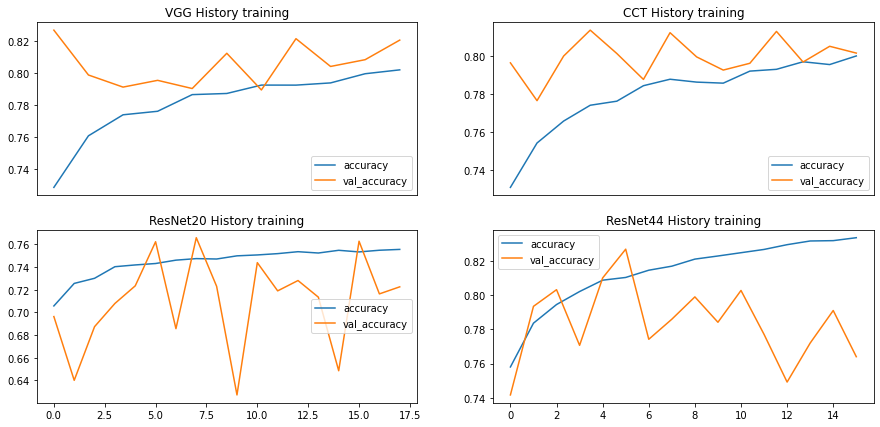

In [98]:
plt.rcParams["figure.figsize"] = (15,7)
fig, axs = plt.subplots(2,2)
pd.DataFrame(history_vgg_2.history)[["accuracy","val_accuracy"]].plot(ax = axs[0,0])
axs[0,0].set_title("VGG History training")
axs[0,0].get_xaxis().set_ticks([])
pd.DataFrame(history_cct_2.history)[["accuracy","val_accuracy"]].plot(ax=axs[0,1])
axs[0,1].set_title("CCT History training")
axs[0,1].get_xaxis().set_ticks([])
pd.DataFrame(history_resnet20_2.history)[["accuracy","val_accuracy"]].plot(ax=axs[1,0])
axs[1,0].set_title("ResNet20 History training")
pd.DataFrame(history_resnet44_2.history)[["accuracy","val_accuracy"]].plot(ax = axs[1,1])
axs[1,1].set_title("ResNet44 History training")

<strong>Accruacy comparaison between the model on the test set</strong>

| Model | Accuracy | #Params | Time per epoch |
| :-----: | :--------: | :-------: | :--------------: |
| VGG | 77.98% | 0.8M | 5s |
| CCT | 70.24% | 0.63M | 9s |
| ResNet20 | 63.44%| 0.12M| 5s|
|ResNet44 | <strong>81.2%</strong>|0.69M| 21s |

Again VGG as a very good accuracy and very low computational time.

<strong>Train with a mixup augmentation data ([mixup: BEYOND EMPIRICAL RISK MINIMIZATION](https://arxiv.org/pdf/1802.05300.pdf))</strong>

<strong> Implement the mixup data augmentation<strong>

In [25]:
def sample_beta_distribution(size, concentration_0=1., concentration_1=1.):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def mix_up(ds_one, ds_two, alpha=0.2):
    # Unpack two datasets
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two
    batch_size = tf.shape(images_one)[0]

    # Sample lambda and reshape it to do the mixup
    l = sample_beta_distribution(batch_size, alpha, alpha)
    x_l = tf.reshape(l, (batch_size, 1, 1, 1))
    y_l = tf.reshape(l, (batch_size, 1))

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = images_one * x_l + images_two * (1 - x_l)
    labels = labels_one * y_l + labels_two * (1 - y_l)
    return (images, labels)



In [26]:
def run_experiment3(model,name):
    cleaning_network = create_label_cleaner_clipped(model)
    cleaning_network.load_weights("./tmp/checkpoint_cleaning_network_"+name+"_clipped")
    train = imgs_prep[5000:50000]
    test = imgs_prep[:5000]
    train_labels = smooth_labels(keras.utils.to_categorical(labels[5000:50000]))
    test_cleaned_labels = smooth_labels(keras.utils.to_categorical(labels[:5000]))
    train_cleaned_labels = tf.argmax(cleaning_network.predict([train[2000:],train_labels[2000:]]),axis=1)
    train_cleaned_labels = smooth_labels(keras.utils.to_categorical(tf.concat([labels[5000:7000],train_cleaned_labels],axis=0)))
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    val_samples = 2000
    val, val_cleaned_labels = train[:val_samples], train_cleaned_labels[:val_samples]
    new_train, new_train_cleaned_labels = train[val_samples:], train_cleaned_labels[val_samples:]

    train_ds_one = (
        tf.data.Dataset.from_tensor_slices((new_train, new_train_cleaned_labels))
        .shuffle(batch_size * 100)
        .batch(batch_size)
    )
    train_ds_two = (
        tf.data.Dataset.from_tensor_slices((new_train, new_train_cleaned_labels))
        .shuffle(batch_size * 100)
        .batch(batch_size)
    )
    # Because we will be mixing up the images and their corresponding labels, we will be
    # combining two shuffled datasets from the same training data.
    train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

    val_ds = tf.data.Dataset.from_tensor_slices((val, val_cleaned_labels)).batch(batch_size)

    test_ds = tf.data.Dataset.from_tensor_slices((test, test_cleaned_labels)).batch(batch_size)

    train_ds_mu = train_ds.map(
        lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=0.2), num_parallel_calls=tf.data.AUTOTUNE
    )
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "./tmp/checkpoint_"+str(model.name)
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="accuracy",
        save_best_only=True,
        save_weights_only=True,
    )
    early_stoping_callback = keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)
    history = model.fit(
        train_ds_mu,
        validation_data=val_ds,
        batch_size=batch_size,
        epochs=num_epochs,
        callbacks=[checkpoint_callback,early_stoping_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(test_ds)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [79]:
learning_rate = 1e-4
vgg_classifier = create_vgg_classifier(3)
vgg_classifier._name = 'model_3_vgg_classifier'
vgg_classifier.load_weights("./tmp/checkpoint_model_vgg_classifier")
history = run_experiment3(vgg_classifier,"vgg")

Epoch 1/100
336/336 [==============================] - 7s 17ms/step - loss: 1.3476 - accuracy: 0.6963 - top-5-accuracy: 0.9637 - val_loss: 1.0677 - val_accuracy: 0.7560 - val_top-5-accuracy: 0.9785
Epoch 2/100
336/336 [==============================] - 5s 15ms/step - loss: 1.2886 - accuracy: 0.7195 - top-5-accuracy: 0.9722 - val_loss: 1.1001 - val_accuracy: 0.7445 - val_top-5-accuracy: 0.9800
Epoch 3/100
336/336 [==============================] - 5s 16ms/step - loss: 1.2646 - accuracy: 0.7295 - top-5-accuracy: 0.9754 - val_loss: 1.1320 - val_accuracy: 0.7245 - val_top-5-accuracy: 0.9740
Epoch 4/100
336/336 [==============================] - 5s 16ms/step - loss: 1.2519 - accuracy: 0.7380 - top-5-accuracy: 0.9771 - val_loss: 1.0906 - val_accuracy: 0.7445 - val_top-5-accuracy: 0.9750
Epoch 5/100
336/336 [==============================] - 5s 15ms/step - loss: 1.2429 - accuracy: 0.7417 - top-5-accuracy: 0.9763 - val_loss: 1.0643 - val_accuracy: 0.7485 - val_top-5-accuracy: 0.9800
Epoch 6/10

In [80]:
cct_classifier = create_cct_classifier()
cct_classifier.load_weights("./tmp/checkpoint_model_cct_classifier")
cct_classifier._name = 'model_cct_classifier_3'
history = run_experiment3(cct_classifier,"cct")

Epoch 1/100
336/336 [==============================] - 13s 30ms/step - loss: 1.3222 - accuracy: 0.6973 - top-5-accuracy: 0.9716 - val_loss: 1.2028 - val_accuracy: 0.6935 - val_top-5-accuracy: 0.9680
Epoch 2/100
336/336 [==============================] - 9s 28ms/step - loss: 1.2756 - accuracy: 0.7180 - top-5-accuracy: 0.9768 - val_loss: 1.2427 - val_accuracy: 0.6770 - val_top-5-accuracy: 0.9630
Epoch 3/100
336/336 [==============================] - 10s 29ms/step - loss: 1.2577 - accuracy: 0.7228 - top-5-accuracy: 0.9782 - val_loss: 1.1362 - val_accuracy: 0.7185 - val_top-5-accuracy: 0.9820
Epoch 4/100
336/336 [==============================] - 9s 28ms/step - loss: 1.2403 - accuracy: 0.7315 - top-5-accuracy: 0.9806 - val_loss: 1.1469 - val_accuracy: 0.7155 - val_top-5-accuracy: 0.9755
Epoch 5/100
336/336 [==============================] - 9s 28ms/step - loss: 1.2367 - accuracy: 0.7343 - top-5-accuracy: 0.9794 - val_loss: 1.2146 - val_accuracy: 0.6835 - val_top-5-accuracy: 0.9735
Epoch 6/

In [27]:
resnet20_classifier = create_resnet_classifier(1)
resnet20_classifier._name = 'model_resnet20_classifier_3'
resnet20_classifier.load_weights("./tmp/checkpoint_model_resnet20_classifier")
history = run_experiment3(resnet20_classifier,"resnet20")

2022-03-23 20:27:49.994652: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


Epoch 1/100
336/336 [==============================] - 9s 19ms/step - loss: 1.3970 - accuracy: 0.6735 - top-5-accuracy: 0.9672 - val_loss: 1.9455 - val_accuracy: 0.4945 - val_top-5-accuracy: 0.9295
Epoch 2/100
336/336 [==============================] - 6s 17ms/step - loss: 1.3415 - accuracy: 0.6902 - top-5-accuracy: 0.9715 - val_loss: 1.6301 - val_accuracy: 0.5290 - val_top-5-accuracy: 0.9120
Epoch 3/100
336/336 [==============================] - 6s 17ms/step - loss: 1.3213 - accuracy: 0.7005 - top-5-accuracy: 0.9738 - val_loss: 1.5574 - val_accuracy: 0.5465 - val_top-5-accuracy: 0.9035
Epoch 4/100
336/336 [==============================] - 6s 17ms/step - loss: 1.3178 - accuracy: 0.7030 - top-5-accuracy: 0.9734 - val_loss: 1.5282 - val_accuracy: 0.5950 - val_top-5-accuracy: 0.9160
Epoch 5/100
336/336 [==============================] - 6s 17ms/step - loss: 1.3134 - accuracy: 0.7042 - top-5-accuracy: 0.9737 - val_loss: 1.5379 - val_accuracy: 0.5715 - val_top-5-accuracy: 0.9185
Epoch 6/10

In [82]:
resnet44_classifier = create_resnet_classifier(7)
resnet44_classifier._name = 'model_resnet44_classifier_3'
resnet44_classifier.load_weights("./tmp/checkpoint_model_resnet44_classifier")
history = run_experiment3(resnet44_classifier,"resnet44")

Epoch 1/100
336/336 [==============================] - 29s 70ms/step - loss: 1.3184 - accuracy: 0.7261 - top-5-accuracy: 0.9641 - val_loss: 1.0387 - val_accuracy: 0.7840 - val_top-5-accuracy: 0.9810
Epoch 2/100
336/336 [==============================] - 23s 68ms/step - loss: 1.2688 - accuracy: 0.7439 - top-5-accuracy: 0.9722 - val_loss: 1.0833 - val_accuracy: 0.7470 - val_top-5-accuracy: 0.9710
Epoch 3/100
336/336 [==============================] - 23s 67ms/step - loss: 1.2502 - accuracy: 0.7510 - top-5-accuracy: 0.9726 - val_loss: 1.0187 - val_accuracy: 0.7825 - val_top-5-accuracy: 0.9705
Epoch 4/100
336/336 [==============================] - 23s 67ms/step - loss: 1.2320 - accuracy: 0.7606 - top-5-accuracy: 0.9732 - val_loss: 1.2045 - val_accuracy: 0.7070 - val_top-5-accuracy: 0.9720
Epoch 5/100
336/336 [==============================] - 22s 67ms/step - loss: 1.2231 - accuracy: 0.7591 - top-5-accuracy: 0.9737 - val_loss: 1.0986 - val_accuracy: 0.7350 - val_top-5-accuracy: 0.9715
Epoch

In [115]:
# [BUILD A MORE SOPHISTICATED PREDICTIVE MODEL]

# write your code here...
vgg_model_1 = create_vgg_classifier(3)
vgg_model_1.load_weights("./tmp/checkpoint_model_vgg_classifier")

def model_I(images):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    img_prep = prep_pixels(images)
    return np.argmax(vgg_model_1.predict(img_prep),axis=1)
   
    # write your code here...

In [116]:
# [ADD WEAKLY SUPERVISED LEARNING FEATURE TO MODEL I]

# write your code here...
vgg_model_2 = create_vgg_classifier(3)
vgg_model_2.load_weights("./tmp/checkpoint_model_vgg_classifier_2")

def model_II(images):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    img_prep = prep_pixels(images)
    return np.argmax(vgg_model_2.predict(img_prep),axis=1)
    # write your code here...

In [117]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [122]:
prevision1 = model_I(test_imgs)

In [121]:
prevision2 = model_II(test_imgs)

In [123]:
y_test = np.reshape(y_test,(10_000))
print("Evaluation Model I :",np.sum(prevision1==y_test)/len(y_test))
print("Evaluation Model II :",np.sum(prevision2==y_test)/len(y_test))

Evaluation Model I : 0.6564
Evaluation Model II : 0.7115


## 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose. 

In [29]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [96]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
#test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(baseline_model, y_test, test_imgs)

The overall accuracy is $0.24$, which is better than random guess (which should have a accuracy around $0.10$). For the project, you should try to improve the performance by the following strategies:

- Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
- Use both `clean_noisy_trainset` and `noisy_trainset` for model training via **weakly supervised learning** methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
- Apply techniques such as $k$-fold cross validation to avoid overfitting;
- Any other reasonable strategies.